# CIS6800: Project 2: YOLO
### Due:
* Part A - Sept. 18 at 11:59 p.m.
* Part B - Sept. 25 at 11:59 p.m.

### Instructions:
* Part A consists of parts 1-4 and is due on September 18th at 11:59 p.m. EDT.
* Part B consists of parts 5-8 and is due on September 25th at 11:59 p.m. EDT.
* As the autograder uses the definitions for functions and classes you submit,
please do not modify the name of any function or class provided.
* This is a group assignment with one submission per group. It is expected that each member of the group will contribute to solving each question. Be sure to specify your teammates when you submit to Gradescope! Collaborating with other groups is not permitted.
* There is no single answer to most problems in deep learning, therefore the questions will often be underspecified. You need to fill in the blanks and submit a solution that solves the (practical) problem. Document the choices (hyperparameters, features, neural network architectures, etc.) you made where specified.
* All the code should be written in Python.
* You may include any code used in previous projects.

## Introduction
Object detection is a fundamental task in computer vision. The problem of object recognition essentially consists of first localizing the object and then classifying it with a semantic label. In recent deep learning based methods, YOLO is an extremely fast real time multi object detection algorithm.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_1.png"/></div>

<center>Figure 1: This is a demo of what object detection does. The color indicates different semantic class.</center>  
  
In this project, we provide 10K street scene images with correponding labels as training data. The image dimension is $128 \times 128 \times 3$, and the labels include the semantic class and the bounding box corresponding to each object in the image. Note that a small portion of these ground-truth labels are not a little bit noisy and the quantity of the training set is not very large, so we do not expect you to learn a super robust object detector.

## Data Preprocessing
For this section, you will need to write code to preprocess the ground truth labels for the YOLO algorithm. The
labels are provided in the "label" folder. The format of the labels are (class, $x_1$, $y_1$, $x_2$, $y_2$), where $x_1$, $y_1$ are the top left corner of the bounding box and $x_2$, $y_2$ are the bottom right corner of the bounding box.  
  
<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_2.png"/></div>

<center>Figure 2: This figure demonstrates the format of ground-truth labels that YOLO algorithm requires.</center>  
  
For each image, you are required to convert the provided labels into the $8 \times 8 \times 8$ ground truth matrix, which has the same dimension as the output of YOLO detection network. The instructions of this conversion is as follows:
* We consider a $16 \times 16$ image patch as a grid cell and thus divide the full image into $8 \times 8$ patches in the 2D spatial dimension. In the output activation space, one grid cell represents one 16x16 image patch with corresponding aligned locations.
* For simplified YOLO, we only use one anchor box, where we assume the anchor size is the same as the grid cell size. If the center of an object falls into a grid cell, that grid cell is responsible for detecting that object. This means that there is only one anchor for each object instance.
* For each anchor, there are 8 channels, which encode Pr(Objectness), $x$, $y$, $w$, $h$, P(class=pedestrian),  P(class=traffic light), and P(class=car).
* The Pr(Objectness) is the probability of whether this anchor is an object or background. When assigning the ground-truth for this value, "1" indicates object and "0" indicates background.
* The channels 2-5, $x$, $y$ coordinates represent the center of the box relative to the bounds of the grid cell; $w$, $h$ is relative to the image width and height.
* In channels 6-8, you need to convert the ground truth semantic label of each object into one-hot coding for each anchor boxes.
* Note that if the anchor box does not have any object (Pr=0), you donâ€™t need to assign any values to channels 2-8, since we will not use them during training.
* The dimensions are ordered (channels, x, y).

## Model Architecture
You are required to implement the model architecture using the following parameters. This model takes input with dimension of $128 \times 128 \times 3$ and outputs an activation with dimension of $8 \times 8 \times 8$.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_3.png"/></div>
<center>Figure 3: This figure demonstrates how to compute IoU.</center>

| Layer | Hyperparameters |
| :-: | :-: |
| conv1 | Kernel size $= 4 \times 4 \times 32$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv2 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv3 | Kernel size $= 4 \times 4 \times 128$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv4 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv5 | Kernel size $= 4 \times 4 \times 512$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv6 | Kernel size $= 4 \times 4 \times 1024$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv7 | Kernel size $= 4 \times 4 \times 256$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| transposed_conv8 | Kernel size $= 4 \times 4 \times 64$, stride $=2$, pad $=1$. Followed by BatchNorm and ReLU. |
| conv9 | Kernel size $= 3 \times 3 \times 8$, stride $=1$, pad $=1$. |


## Training Details
During training, the localization and classification errors are optimized jointly. The loss function is shown
as below.  $i$ indicates number of grid cells and $j$ indicates number of anchor boxes at each grid cell. In our
case, there is only one anchor box at each grid cell and $B = 1$.

$$ \text{Loss} = 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(x_i - \hat{x}_i\right)}^2 + {\left(y_i - \hat{y}_i\right)}^2\right]} + 
{\lambda_\text{coord} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left[{\left(\sqrt{w_i} - \sqrt{\hat{w}_i}\right)}^2 + {\left(\sqrt{h_i} - \sqrt{\hat{h}_i}\right)}^2\right]} \\\\ + 
{\sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{obj} \left(C_i - \hat{C}_i\right)^2} + 
{\lambda_\text{no obj} \sum_{i=0}^{S^2} \sum_{j=0}^B \mathbb{1}_{ij}^\text{no obj} \left(C_i - \hat{C}_i\right)^2} + 
{\sum_{i=0}^{S^2} \mathbb{1}_{ij}^\text{obj} \sum_{c\, \in\, \text{classes}} \left(p_i(c) - \hat{p}_i(c)\right)^2}$$

* In our case there is only one anchor box at each grid, hence $B = 1$.
* $S^2 =$ total number of grid cells.
* $\mathbb{1}_{ij}^\text{obj} = 1$ if an object appears in grid cell $i$ and 0 otherwise.
* $\mathbb{1}_{ij}^\text{no obj}$ is the compliment of $\mathbb{1}_{ij}^\text{obj}$.
* $\hat{C}_i =$ Box confidence score $=$ Pr(box contains object) $\times$ IoU
* IoU $=$ Intersection over union between the predicted and the ground truth.
* $\hat{p}_i(c) =$ conditional class probability of class $c$ in cell $i$.

$\lambda_\text{coord}$ and and $\lambda_\text{no obj}$ are two hyperparameters for coordinate predictions and non-objectness classification. We set $\lambda_\text{coord} = 5$ and and $\lambda_\text{no obj} = 0.5$.

Each grid cell predicts 1 bounding box, confidence score for those boxes and class conditional probabilities.

The confidence Score reflects the degree of confidence that the box contains an object and how accurate the box is. If no object exists in the cell then the confidence score should be 0 else the confidence score should be equal to the IOU between the predicted box and the ground truth box.

During training, you can set learning rate of 10e-3 using Adam optimizer with default beta 1 and beta 2. You are encourage to adaptively adjust learning rate during training to see if the model will converge better. You should also visualize the loss over training iterations. You will need to decide at the iteration to stop training based on the loss visualization. (At least 20 epochs of training is required.)

## Post-Processing
During inference, the network is going to predict lots of overlapping redundant bounding boxes. To eliminate the redundant boxes, there are basically two steps:

1. Get rid of predicted boxes with low objectness probability (Pr $< 0.6$).
2. For each class, calculate the IoU for all the bounding boxes and cluster boxes with IoU > 0.5 as a group. For each group, find the one with highest Pr and suppress the other boxes. This is referred as non-max suppression.

To evaluate the performance of your YOLO implementation, compute the mean Average Precision (mAP) of inference. Predicted bounding boxes are a match with ground truth bounding boxes if they share the same label and have an IoU with the ground truth bounding box of greater than 0.5. These matches can be used to calculate a precision/recall curve for each class. The Average Precision for a class is the area under this curve. The mean of these Average Precision values over all the classes in inference gives the mean Average Precision of your network.

<div><img src="https://github.com/LukasZhornyak/CIS680_files/raw/main/HW2/fig2_4.png"/></div>

<center>Figure 4: This figure demonstrates post-process of how to get rid of redundant bounding box.</center>

## Code

In [ ]:
# !pip install pytorch_lightning &> /dev/null

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
from tqdm import tqdm
# from torchsummary import summary

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
seed = 17
torch.manual_seed(seed)

In [ ]:
# Use this function to import the provided data files
def load_data(file_name):
    return np.load(file_name, allow_pickle=True, encoding='latin1')['arr_0']

images = load_data('images.npz') # (9900, 128, 128, 3) 'uint8'
raw_labels = load_data('labels.npz') # (9000,) 'np.float64'

proc_label = torch.load('proc_label.pt') # (9900, 8, 8, 8) Tensor
proc_image = torch.load('proc_image.pt') # (9900, 3, 128, 128) Tensor

**Generate customized dataset**

In [ ]:
# # For image, transpose axis + tensor
# proc_image = torch.zeros((9900,3,128,128))
# for i in range(images.shape[0]):
#     proc_image[i] = torch.from_numpy(images[i].transpose(2,0,1))

# # For labels, get processed label(N,8,8,8) with only one object in each cell
# proc_label = torch.zeros((9900,8,8,8))
# for i in range(raw_labels.shape[0]):
#     proc_label[i] = torch.from_numpy(process_labels(raw_labels[i]))

# torch.save(proc_image, 'proc_image.pt')
# torch.save(proc_label, 'proc_label.pt')

In [ ]:
# Visualize the image with its bounding box
def visualImgBbox(img, raw_label, title=None):
    color_dict = {0:'r', 1:'b', 2:'g'}
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    if title:
        plt.title(title)
    for bbox in raw_label:
        top_x, top_y = bbox[1], bbox[2]
        width, height = bbox[3] - bbox[1], bbox[4] - bbox[2]
        plt.gca().add_patch(Rectangle((top_x, top_y), width, height, linewidth=1, edgecolor=color_dict[bbox[0]],facecolor='none'))

In [ ]:
# This function should compute the 8X8X8 label from the raw labels for the corresponding image.
def process_labels(raw_labels):
    '''
    Input:
    raw_labels (N,5): Raw annotation labels for one image
    Output:
    labels (8,8,8): Ground truth matrix generated from the raw label
    '''
    labels = np.zeros((8,8,8))
    # Dictionary to check for overwritten label in same bbox
    check_dict = {}
    for i, label in enumerate(raw_labels):
        # Find center pixel
        x_c, y_c = (label[1] + label[3]) // 2, (label[2] + label[4]) // 2
        # Find grid cell x and y index
        y_grid_idx, x_grid_idx = int(y_c // 16), int(x_c // 16)
        # Find x and y pixel coordinate ratio relative to the bounds of the grid cell
        x_c_rlt, y_c_rlt = x_c % 16 / 16, y_c % 16 / 16
        # Find ratio of bounding box width and height relative to the image width and height
        w, h = (label[3] - label[1])/128, (label[4] - label[2])/128
        # Find class label
        class_label = label[0]
        # Put current label grid index into dictionary for overwritten check
        if (y_grid_idx, x_grid_idx) in check_dict.values():
            labels[:, y_grid_idx, x_grid_idx] = 0
        check_dict[i] = (y_grid_idx, x_grid_idx)
        
        # Channel 1: Pr(Objectness)
        labels[0, y_grid_idx, x_grid_idx] = 1
        # Channel 2~5: x,y,w,h
        labels[1:5, y_grid_idx, x_grid_idx] = np.array([x_c_rlt, y_c_rlt, w, h])
        # Channel 6~8: Class proabilities
        labels[5 + int(class_label), y_grid_idx, x_grid_idx] = 1

    return labels

In [ ]:
# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels(labels, img_dim=128):
    # Get number of bounding boxes and initialize the empty reconstructed raw label container
    N = np.count_nonzero(labels[3])
    raw_labels = np.zeros((N,5))
    # Get grid cell x and y index
    y_grid_idx, x_grid_idx = np.nonzero(labels[3]) # Detect non-zero element in third channel to capture all cells
    # Get channel 2 & 3: x and y coordinate of bounding box center relative to the bounds of the grid cell
    x_c_rlt, y_c_rlt = labels[1] * 16, labels[2] * 16
    # Iterate over all bounding boxes
    for i in range(N):
        # Single grid cell x and y index
        y_curr, x_curr = y_grid_idx[i], x_grid_idx[i]
        # Find class label
        # class_index = np.nonzero(labels[-3:, y_curr, x_curr])[0]
        class_index = np.argmax(labels[-3:, y_curr, x_curr])
        raw_labels[i,0] = class_index
        # Find top left and bottom right corner x and y coordinate of bounding box relative to image top left corner
        x_1 = x_c_rlt[y_curr, x_curr] + x_curr * 16 - labels[3][y_curr, x_curr] / 2 * img_dim
        y_1 = y_c_rlt[y_curr, x_curr] + y_curr * 16 - labels[4][y_curr, x_curr] / 2 * img_dim
        x_2 = x_c_rlt[y_curr, x_curr] + x_curr * 16 + labels[3][y_curr, x_curr] / 2 * img_dim
        y_2 = y_c_rlt[y_curr, x_curr] + y_curr * 16 + labels[4][y_curr, x_curr] / 2 * img_dim
        # Fill x_1, y_1, x_2, y_2 into container
        raw_labels[i,1:] = np.array([x_1, y_1, x_2, y_2])
    return raw_labels


# This function should perform the inverse operation of process_labels().
def reconstruct_raw_labels_scoreAdd(labels, img_dim=128):
    # Get number of bounding boxes and initialize the empty reconstructed raw label container
    N = np.count_nonzero(labels[3])
    raw_labels = np.zeros((N,6))
    # Get grid cell x and y index
    y_grid_idx, x_grid_idx = np.nonzero(labels[3]) # Detect non-zero element in third channel to capture all cells

    # If there is no element then return None
    if len(y_grid_idx) == 0:
        return None
    # Get channel 2 & 3: x and y coordinate of bounding box center relative to the bounds of the grid cell
    x_c_rlt, y_c_rlt = labels[1] * 16, labels[2] * 16
    # Iterate over all bounding boxes
    for i in range(N):
        # Single grid cell x and y index
        y_curr, x_curr = y_grid_idx[i], x_grid_idx[i]
        # Find class label
        # class_index = np.nonzero(labels[-3:, y_curr, x_curr])[0]
        class_index = np.argmax(labels[-3:, y_curr, x_curr])
        raw_labels[i,0] = class_index
        # Find top left and bottom right corner x and y coordinate of bounding box relative to image top left corner
        x_1 = x_c_rlt[y_curr, x_curr] + x_curr * 16 - labels[3][y_curr, x_curr] / 2 * img_dim
        y_1 = y_c_rlt[y_curr, x_curr] + y_curr * 16 - labels[4][y_curr, x_curr] / 2 * img_dim
        x_2 = x_c_rlt[y_curr, x_curr] + x_curr * 16 + labels[3][y_curr, x_curr] / 2 * img_dim
        y_2 = y_c_rlt[y_curr, x_curr] + y_curr * 16 + labels[4][y_curr, x_curr] / 2 * img_dim
        # Fill in confidence score
        raw_labels[i,1] = labels[0, y_curr, x_curr]
        # Fill x_1, y_1, x_2, y_2 into container
        raw_labels[i,2:] = np.array([x_1, y_1, x_2, y_2])
    return raw_labels

### YOLO Model

In [ ]:
class YOLO(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torch.nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=1024, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=256, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(in_channels=64, out_channels=8, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

    def model_url(self):
        return "drive.google.com/uc?id=1PUf70_cTgvKzCUXRE2xqOcTHAr1aIi_A&amp;export=download&amp;confirm=t&amp;uuid=b0a08b80-f9af-4080-9c99-c20b467688fd"

    def load_from_url(self):
        model = YOLO().cuda()
        model.load_state_dict(torch.load('model_v2.pth'))
        return model

In [ ]:
def low_confidence_suppression(label):
    '''
    Input: 
    label: (8,8,8) Single image label
    Output:
    out_label: (8,8,8) Single image label after low confidence suppression
    '''
    out_label = label.copy()
    obj_mask = label[0] < 0.6
    out_label[:,obj_mask] = 0
    return out_label


def non_max_suppression(label):
    '''
    Input: 
    label: (8,8,8) Single image label after low confidence suppression
    Output:
    label: (8,8,8) Single image label after performing NMS
    '''
    # Copy of label, avoid making changes in-place
    out_label = label.copy()
    # Get class prediction for all cells
    pred_class = np.argmax(out_label[5:], axis=0)
    # Iterate through all classes
    for class_idx in range(3):
        # Get all cell indexes (y,x) that are in same class
        pred_index = np.argwhere(np.logical_and(pred_class == class_idx, out_label[0] > 0)) # (N,2)
        # Get labels for all cells
        all_labels = out_label[:, pred_index[:,0], pred_index[:,1]].T # (N,8)
        # Put all labels within dictionary
        all_dict = {i:(pred_index[i], all_labels[i]) for i in range(pred_index.shape[0])} # (N,)
        # Group cells if their IOU > 0.5
        total_group = []
        while len(all_dict) != 0:
            curr_group = []
            curr_group_idx = []
            # Pop first item in dictionary
            first_item_key = next(iter(all_dict))
            curr_item = all_dict.pop(first_item_key)
            curr_group.append(curr_item)
            # Iterate through all cells and group them if two of their IOU > 0.5
            for curr_dict in all_dict:
                if calc_IOU_nms(curr_item[1], all_dict[curr_dict][1], curr_item[0], all_dict[curr_dict][0]) > 0.5:
                    curr_group_idx.append(curr_dict)
            for i in range(len(curr_group_idx)):
                curr_group.append(all_dict.pop(curr_group_idx[i]))
            total_group.append(curr_group)
        # Iterate through all labels in the group and only keep the cell with highest Pr(obj)
        discard_cell = []
        if len(total_group) != 0:
            for curr_group in total_group:
                # Add all items' probability in this group for later comparision
                pr_group = []
                for curr_cell in curr_group:
                    pr_group.append(curr_cell[1][0])
                sort_order = np.argsort(pr_group)
                # Iterate through all non-maximum items and add their (y,x) index to discard pile
                for i in sort_order[:-1]:
                    discard_cell.append(curr_group[i][0])
        # Cast list to np.array
        discard_cell = np.array(discard_cell)
        # If the discard cell list is not empty, then eliminate those cells with index stored in discard_cell
        if len(discard_cell) != 0:
            out_label[:, discard_cell[:,0], discard_cell[:,1]] = 0

    return out_label


def calc_IOU_nms(output, target, output_index, target_index):
    '''
    Input:
    output: (8,) Tensor
    target: (8,) Tensor
    output_index: (2,)
    target_index: (2,)
    '''
    # Output box two corner point
    i, j = output_index[0], output_index[1]
    x1, y1 = np.ceil(output[1]*16 + j*16 - output[3]/2*128), np.ceil(output[2]*16 + i*16 - output[4]/2*128)
    x2, y2 = np.ceil(output[1]*16 + j*16 + output[3]/2*128), np.ceil(output[2]*16 + i*16 + output[4]/2*128)
    # Target box two corner point 
    i_, j_ = target_index[0], target_index[1]
    x1_, y1_ = np.ceil(target[1]*16 + j_*16 - target[3]/2*128), np.ceil(target[2]*16 + i_*16 - target[4]/2*128)
    x2_, y2_ = np.ceil(target[1]*16 + j_*16 + target[3]/2*128), np.ceil(target[2]*16 + i_*16 + target[4]/2*128)
    # Get the intersection rectangle corner coordinate
    x_A = max(x1, x1_)
    y_A = max(y1, y1_)
    x_B = min(x2, x2_)
    y_B = min(y2, y2_)
    # Calculate intersection area
    intersection_area = max(0, x_B - x_A) * max(0, y_B - y_A)
    # compute the total area
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x2_ - x1_) * (y2_ - y1_)
    # Calculate the IOU
    iou = intersection_area / (bb1_area + bb2_area - intersection_area)

    return iou

In [ ]:
def calc_IOU_pre(output, target, output_index, target_index):
    '''
    Input:
    output: (8,) Tensor
    target: (8,) Tensor
    output_index: (2,)
    target_index: (2,)
    '''
    # Output box two corner point
    i, j = output_index[0], output_index[1]
    x1, y1 = output[1]*16 + j*16 - output[3]/2*128, output[2]*16 + i*16 - output[4]/2*128
    x2, y2 = output[1]*16 + j*16 + output[3]/2*128, output[2]*16 + i*16 + output[4]/2*128
    # Target box two corner point
    i_, j_ = target_index[0], target_index[1]
    x1_, y1_ = target[1]*16 + j_*16 - target[3]/2*128, target[2]*16 + i_*16 - target[4]/2*128
    x2_, y2_ = target[1]*16 + j_*16 + target[3]/2*128, target[2]*16 + i_*16 + target[4]/2*128
    # Get the intersection rectangle corner coordinate
    x_A = max(x1, x1_)
    y_A = max(y1, y1_)
    x_B = min(x2, x2_)
    y_B = min(y2, y2_)
    # Calculate intersection area
    intersection_area = max(0, x_B - x_A) * max(0, y_B - y_A)
    # compute the total area
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x2_ - x1_) * (y2_ - y1_)
    # Calculate the IOU
    iou = intersection_area / (bb1_area + bb2_area - intersection_area)

    return iou


def precision_recall_curve(predictions, targets, target_class):
    '''
    Input:
    predictions: (N,8,8,8) 
    targets: (N,8,8,8) 
    taret_class: (1,) 
    Output:
    recall: (N,) N batches of list of recall values (M,)
    preciison: (N,) N batches of list of precision values (M,)
    '''
    total_gt_bbox_num = 0
    total_conf = []
    total_pre_TP = []
    total_recall_TP = []
    precision, recall = [], []
    for prediction, target in zip(predictions, targets):
        # Initialize empty precision and recall list for current image
        # curr_precision, curr_recall = [], []
        TP_pre = []
        TP_recall = []
        # Get ground truth bounding box and prediction bounding box length
        gt_mask = target[5 + target_class]
        num_obj = np.sum(gt_mask)
        total_gt_bbox_num += num_obj
        y_gt, x_gt = np.nonzero(gt_mask)
        gt_label = target[:, y_gt, x_gt].T #(M,8)
        # Get prediction labels
        pred_class = np.argmax(prediction[5:], axis=0)
        pred_index = np.argwhere(np.logical_and(pred_class == target_class, prediction[0] > 0))
        pred_label = prediction[:, pred_index[:,0], pred_index[:,1]].T # (N,8)
        # Keep record of total number of ground truth bounding box
        # If there is no correpsonding ground truth bbox then all labels are FP
        if num_obj != 0:
            confidence = pred_label[:,0].tolist()
            total_conf.extend(confidence)
            # Get (N,M) IOU map
            N, M = pred_label.shape[0], gt_label.shape[0]
            Iou = np.zeros((N,M))
            for pred_idx in range(pred_label.shape[0]):
                for gt_idx in range(gt_label.shape[0]):
                    Iou[pred_idx, gt_idx] = calc_IOU_pre(pred_label[pred_idx], gt_label[gt_idx], pred_index[pred_idx], (y_gt[gt_idx], x_gt[gt_idx]))
            # Get sorted prediction confidence score index
            score_sort_index = np.argsort(confidence)[::-1]
            IOU_sort = Iou[score_sort_index]
            # TP & FP binary map
            TPFP_map = (IOU_sort > 0.5).astype(int)
            for ii in range(TPFP_map.shape[0]):
                if 1 in TPFP_map[ii]:
                    # Precision check
                    total_pre_TP.append(1)
                    # Recall check
                    tru_idx = np.argwhere(TPFP_map[ii] == 1)[0]
                    if np.sum(TPFP_map[:ii+1,tru_idx]) == 1:
                        total_recall_TP.append(1)
                    else:
                        total_recall_TP.append(0)
                else:
                    total_pre_TP.append(0)
                    total_recall_TP.append(0)
    score_sort_index_total = np.argsort(total_conf)[::-1]
    total_pre_TP = np.array(total_pre_TP)[score_sort_index_total]
    total_recall_TP = np.array(total_recall_TP)[score_sort_index_total]
    for ii in range(len(total_conf)):
        precision.append(sum(total_pre_TP[:ii+1])/(ii+1))
        recall.append(sum(total_recall_TP[:ii+1])/total_gt_bbox_num)

    return precision, recall, 

def average_precision(predictions, targets, target_class):
    # Precision and recall lists for current class
    precision, recall = precision_recall_curve(predictions, targets, target_class)
    # Calculate average precision
    ap = np.sum((np.array(recall[1:]) - np.array(recall[:-1])) * np.array(precision[1:]))
    return ap, [precision, recall]

def mean_average_precision(predictions, targets):
    ap_total = 0
    pre_recall_curve = []
    for class_idx in range(3):
        ap, pr_curve = average_precision(predictions, targets, class_idx)
        ap_total += ap
        pre_recall_curve.append(pr_curve)
    return ap_total/3, pre_recall_curve

## Instructions and Evaluation

This project is divided into the following parts:

1. Choose an image that has all three classes present (the image has a car, a person, and a traffic light).

    1. Show the chosen image with ground truth bounding boxes visualized. Use green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights. See Figure 1 as an example of what this visualization should look like. (3%)

    2. Convert the image labels to an 8x8x8 representation, and show each channel of the processed labels in the report. Label the visualization of each channel with the associated channel number and visualized value. Example: "Channel 1: Pr(Objectness)". (5%)

    3. To test your data preprocessing code, convert your 8x8x8 representation for this step back to the original input data and ensure that your image with recomputed bounding boxes looks the same as the input. Show this image with bounding box visualizations in your report. This test code for data preprocessing will also be needed in the inference step. (2%)

In [ ]:
# First ten raw label indexes that has all three classes present
allClass = []
for i in range(raw_labels.shape[0]):
    if 0 in raw_labels[i][:,0] and 1 in raw_labels[i][:,0] and 2 in raw_labels[i][:,0]:
        allClass.append(i)
    if len(allClass) > 15:
        break
print(allClass)

[8, 17, 19, 21, 44, 46, 59, 63, 64, 68, 72, 88, 115, 128, 151, 170]


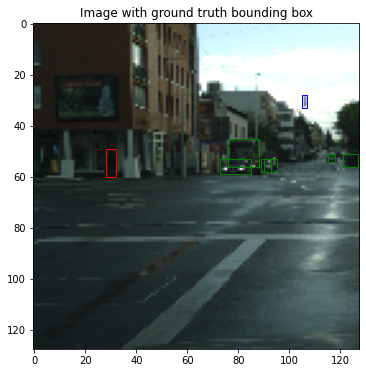

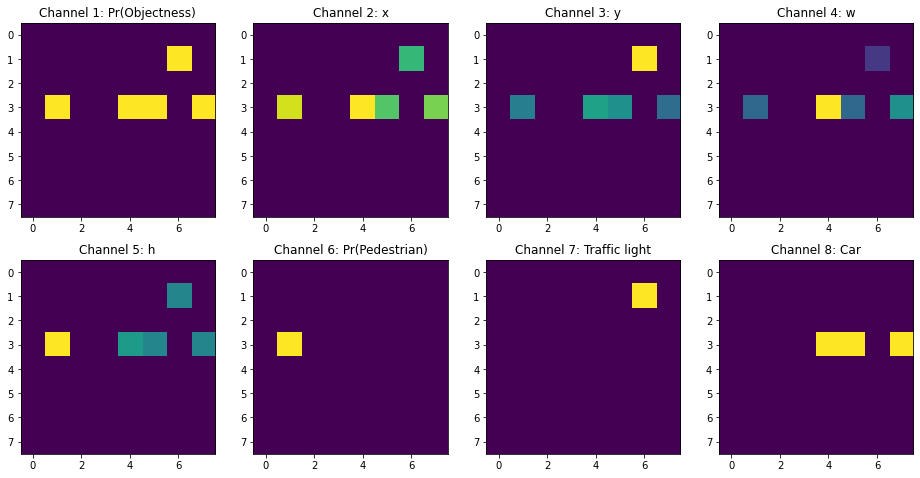

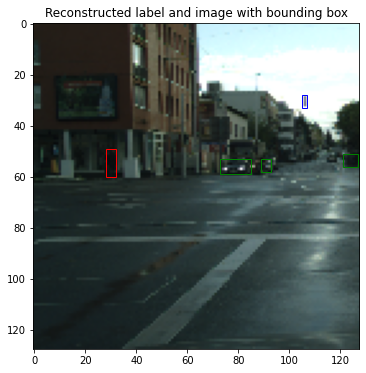

In [ ]:
# Show the chosen image with ground truth bounding boxes visualized
rand_idx = 46
rand_img = images[rand_idx]
rand_raw_label = raw_labels[rand_idx]
# Visualize bounding box on image
visualImgBbox(rand_img, rand_raw_label,'Image with ground truth bounding box')

# Visualize the 8x8x8 label representation
rand_label = process_labels(rand_raw_label)
fig, ax = plt.subplots(2, 4, figsize=(16, 8))
title_dict = {0:'Pr(Objectness)', 1:'x', 2:'y', 3:'w', 4:'h', 5:'Pr(Pedestrian)', 6:'Traffic light', 7:'Car'}
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(rand_label[4*i+j])
        ax[i,j].set_title('Channel %.f: %s' % (4*i+j+1, title_dict[4*i+j]))

# Convert back to the original representation (test cases below should pass).
rec_rand_raw_label = reconstruct_raw_labels(rand_label, img_dim=128)
# Visualize again
visualImgBbox(rand_img, rec_rand_raw_label, 'Reconstructed label and image with bounding box')

2. Implement the loss function. (3%)

In [ ]:
def calc_IOU(output, target, i, j):
    '''
    Input:
    output (8,) Tensor
    target (8,) Tensor
    i: row index of current griding cell
    j: column index of current griding cell
    '''
    # Output box two corner point
    x1, y1 = torch.ceil(output[1]*16 + j*16 - output[3]/2*128), torch.ceil(output[2]*16 + i*16 - output[4]/2*128)
    x2, y2 = torch.ceil(output[1]*16 + j*16 + output[3]/2*128), torch.ceil(output[2]*16 + i*16 + output[4]/2*128)
    # Target box two corner point
    x1_, y1_ = torch.ceil(target[1]*16 + j*16 - target[3]/2*128), torch.ceil(target[2]*16 + i*16 - target[4]/2*128)
    x2_, y2_ = torch.ceil(target[1]*16 + j*16 + target[3]/2*128), torch.ceil(target[2]*16 + i*16 + target[4]/2*128)
    # Get the intersection rectangle corner coordinate
    x_A = torch.max(x1, x1_)
    y_A = torch.max(y1, y1_)
    x_B = torch.min(x2, x2_)
    y_B = torch.min(y2, y2_)
    # Calculate intersection area
    intersection_area = torch.max(torch.zeros(1).cuda(), x_B - x_A) * torch.max(torch.zeros(1).cuda(), y_B - y_A)
    # compute the total area
    bb1_area = (x2 - x1) * (y2 - y1)
    bb2_area = (x2_ - x1_) * (y2_ - y1_)
    # Calculate the IOU
    iou = intersection_area / (bb1_area + bb2_area - intersection_area)

    return iou


def IOU_map(output, target, batch_mask):
    '''
    Input:
    output: (N,8,8,8)
    target: (N,8,8,8)
    mask: (N,8,8)
    Output:
    iou_map: (N,8,8) IOU for all cells with object present (indicated by mask)
    '''
    # Get number of batches
    N_batch = output.shape[0]
    iou_map = torch.zeros((N_batch,8,8)).cuda()
    # Iterate through all batches and find IOU map for each batch
    for batch_idx in range(output.shape[0]):
        mask = batch_mask[batch_idx]
        # Find index of all cells with object present
        obj_idx = torch.nonzero(mask)
        for y_obj, x_obj in obj_idx:
            iou_map[batch_idx, y_obj, x_obj] = calc_IOU(output[batch_idx,:,y_obj, x_obj], target[batch_idx,:,y_obj, x_obj], y_obj, x_obj)
    return iou_map


def yolo_loss(output, target):
    '''
    Input: 
    output Tensor (N,8,8,8)
    target Tensor (N,8,8,8) 
    Output:
    Loss
    '''
    ### Get object mask ###
    obj_mask = target[:,0] # (N,8,8)

    ### Center position loss ###
    pos_loss = torch.sum(obj_mask * torch.sum((output[:,1:3] - target[:,1:3])**2, dim=1))

    ### Width and height loss ###
    wh_loss = torch.sum(obj_mask * torch.sum((torch.sqrt(output[:,3:5]) - torch.sqrt(target[:,3:5]))**2, dim=1))

    ### Class probability loss ###
    prob_loss = torch.sum(obj_mask * torch.sum((output[:,5:] - target[:,5:])**2, dim=1))

    ### Box confidence loss ###
    iou_map = IOU_map(output, target, obj_mask) # (N,8,8)
    confidence_score = obj_mask * iou_map
    no_obj_loss = torch.sum((1 - obj_mask) * torch.pow(output[:,0]- confidence_score,2))
    obj_loss = torch.sum(obj_mask*torch.pow(output[:,0] - confidence_score,2))

    ### Total batch loss ###
    loss = 5 * pos_loss + 5 * wh_loss + prob_loss + obj_loss + 0.5 * no_obj_loss

    return loss

3. Make block diagram of requested architecture. Label the diagram with the parts of your code which implement each component. Explain any deviations you made from the described architecture. (15%)

We have added one more sigmoid activation function in the end of the model to make sure the final model output is limited within $[0,1]$. 

The reason we do that is because the output from the model contains 8 channels where the first one and the last three are probabilties so the value is between $[0,1]$, and for channel 2 to 5 it contains bounding box dimension $[x,y,w,h]$ which are also normalized between $[0,1]$. Therefore, adding a sigmoid function in the end could make sure the model output value is reasonable and produce high accuracy prediction.

In [10]:
%%html
<iframe src="https://drive.google.com/file/d/1Wbbkvwy653E4gZD0b0j6KgGeyW6YIBDK/preview" width="1000" height="400" allow="autoplay"></iframe>

4. Show a plot of the loss over training for your model. (Raw Tensorboard output is not sufficient) (10%) 

**Train Model**

In [ ]:
# Get training and validation dataset with 80% split ratio
train_val_ratio = 0.8
proc_image_train, proc_label_train = proc_image[: int(train_val_ratio * proc_image.shape[0])], proc_label[: int(train_val_ratio * proc_label.shape[0])]
proc_image_val, proc_label_val = proc_image[int(train_val_ratio * proc_image.shape[0]):], proc_label[int(train_val_ratio * proc_label.shape[0]):]

In [ ]:
# Initialize model
model = YOLO().cuda()
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# Define running epoches and batch size
epochs = 20
batch_size = 30
# Number of training batches and validation batches
t_train = proc_image_train.shape[0] // batch_size
training_loss = []
# Number of validation batches
t_val = proc_image_val.shape[0] // batch_size
# Intialize empty list to collect mAP value and precision recall curve
mAP_list = []
pr_total_curve = []


# Begin training model
for epoch in range(epochs):
    n = np.random.permutation(proc_image_train.shape[0])
    running_loss = 0

    # Training
    model.train()
    for m in tqdm(range(t_train)):
        batch_image = proc_image_train[n[m * batch_size : (m + 1) * batch_size]].cuda()
        batch_label = proc_label_train[n[m * batch_size : (m + 1) * batch_size]].cuda() # Tensor (N,8,8,8)
        # zero gradient
        optimizer.zero_grad()
        # forward path
        y_predicted = model(batch_image)
        loss = yolo_loss(y_predicted, batch_label)
        running_loss += loss.item()
        # backpropagating
        loss.backward()
        # optimizes the weights
        optimizer.step()

    # Validation step (Collect mAP and precision, recall curve)
    model.eval()
    val_output = torch.zeros(proc_image_val.shape[0],8,8,8)
    for val_batch_idx in range(t_val):
        val_curr_output = model(proc_image_val[val_batch_idx*batch_size : (val_batch_idx+1)*batch_size].cuda())
        val_output[val_batch_idx*batch_size : (val_batch_idx+1)*batch_size] = val_curr_output
    predictions = val_output.cpu().detach().numpy()
    targets = proc_label_val.numpy()
    mAP, pr_curve = mean_average_precision(predictions, targets)
    mAP_list.append(mAP)
    pr_total_curve.append(pr_curve)

    # Print out each epoch's loss
    print('Epoch %.f: Loss: %.2f mAP: %.3f' % (epoch, running_loss / (t * batch_size), mAP))
    # Keep track of each epoch's training loss
    training_loss.append(running_loss / (t * batch_size))

100%|██████████| 264/264 [03:31<00:00,  1.25it/s]


Epoch 0: Loss: 6.72 mAP: 0.018


100%|██████████| 264/264 [03:34<00:00,  1.23it/s]


Epoch 1: Loss: 5.55 mAP: 0.036


100%|██████████| 264/264 [03:36<00:00,  1.22it/s]


Epoch 2: Loss: 5.04 mAP: 0.061


100%|██████████| 264/264 [03:36<00:00,  1.22it/s]


Epoch 3: Loss: 4.65 mAP: 0.070


100%|██████████| 264/264 [03:35<00:00,  1.22it/s]


Epoch 4: Loss: 4.23 mAP: 0.088


100%|██████████| 264/264 [03:33<00:00,  1.23it/s]


Epoch 5: Loss: 3.81 mAP: 0.070


100%|██████████| 264/264 [03:35<00:00,  1.23it/s]


Epoch 6: Loss: 3.35 mAP: 0.106


100%|██████████| 264/264 [03:33<00:00,  1.24it/s]


Epoch 7: Loss: 2.92 mAP: 0.121


100%|██████████| 264/264 [03:36<00:00,  1.22it/s]


Epoch 8: Loss: 2.49 mAP: 0.101


100%|██████████| 264/264 [03:36<00:00,  1.22it/s]


Epoch 9: Loss: 2.15 mAP: 0.131


100%|██████████| 264/264 [03:35<00:00,  1.22it/s]


Epoch 10: Loss: 1.88 mAP: 0.141


100%|██████████| 264/264 [03:35<00:00,  1.22it/s]


Epoch 11: Loss: 1.66 mAP: 0.148


100%|██████████| 264/264 [03:36<00:00,  1.22it/s]


Epoch 12: Loss: 1.51 mAP: 0.153


100%|██████████| 264/264 [03:36<00:00,  1.22it/s]


Epoch 13: Loss: 1.37 mAP: 0.174


100%|██████████| 264/264 [03:38<00:00,  1.21it/s]


Epoch 14: Loss: 1.26 mAP: 0.170


100%|██████████| 264/264 [03:34<00:00,  1.23it/s]


Epoch 15: Loss: 1.18 mAP: 0.179


100%|██████████| 264/264 [03:33<00:00,  1.24it/s]


Epoch 16: Loss: 1.12 mAP: 0.161


100%|██████████| 264/264 [03:34<00:00,  1.23it/s]


Epoch 17: Loss: 1.06 mAP: 0.179


100%|██████████| 264/264 [03:32<00:00,  1.24it/s]


Epoch 18: Loss: 1.01 mAP: 0.198


100%|██████████| 264/264 [03:32<00:00,  1.24it/s]


Epoch 19: Loss: 1.00 mAP: 0.189


Text(0, 0.5, 'Loss')

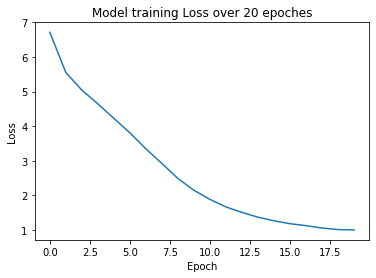

In [ ]:
# plot the epoch loss curve
plt.title('Model training Loss over 20 epoches')
plt.plot(training_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')

**Save Model**

In [ ]:
# torch.save(model.state_dict(), 'model_v3_split.pth')

**Load Model**

In [ ]:
model = YOLO().cuda()
model.load_state_dict(torch.load('model_v2.pth'))

<All keys matched successfully>

5. Show a plot of the mean Average Precision over training for your model. (10%)

Text(0.5, 1.0, 'Mean Average Precision over training in 20 epoches')

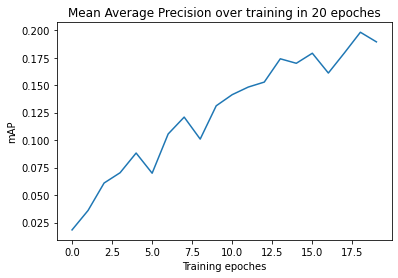

In [ ]:
plt.plot(mAP_list)
plt.xlabel('Training epoches')
plt.ylabel('mAP')
plt.title('Mean Average Precision over training in 20 epoches')

6. For one image in the inference step, show the predicted bounding boxes in the image before performing any elimination. Then, show the annotated image after the low probability bounding boxes are removed. Finally, show image after performing non-max suppression. Label each of these visualizations. See Figure 4 as an example of what this visualization should look like. (15%)

In [ ]:
def visualImgBbox_noColor(img, raw_label, title=None):
    plt.figure(figsize=(6,6))
    plt.imshow(img)
    if title:
        plt.title(title)
    for bbox in raw_label:
        top_x, top_y = bbox[1], bbox[2]
        width, height = bbox[3] - bbox[1], bbox[4] - bbox[2]
        plt.gca().add_patch(Rectangle((top_x, top_y), width, height, linewidth=1, edgecolor='b', facecolor='none'))

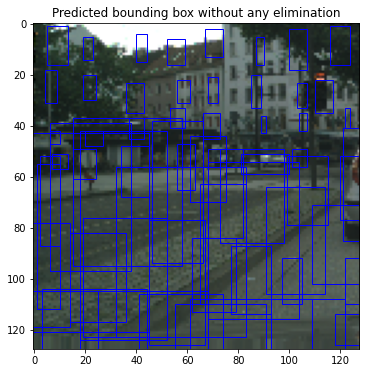

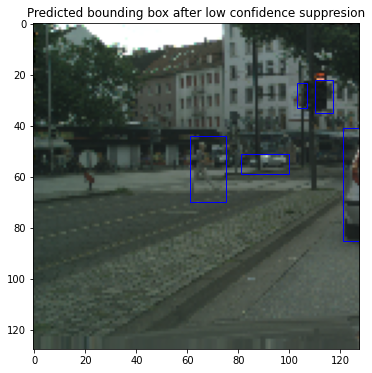

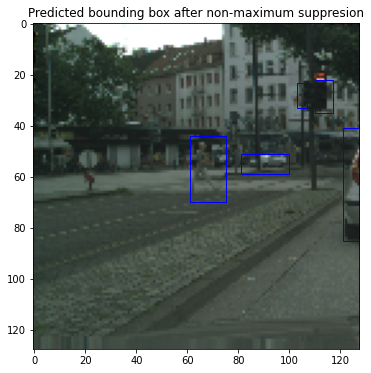

In [ ]:
# Customized function to transform raw image to proper type to feed into model
def imageEval(image):
    return torch.from_numpy(image.astype(np.float32).transpose(2,0,1))[None,:].cuda()

# Change model to evaluation
model.eval()
# Get one random image and feed into model
rand_idx = 151
rand_img = images[rand_idx]
sample_pred = model(imageEval(rand_img)) # (1,8,8,8)
sample_pred_ = sample_pred.cpu().detach().numpy().squeeze()

### Visualization of prediction without any elimination ###
sample_rect = reconstruct_raw_labels(sample_pred_, img_dim=128)
visualImgBbox_noColor(rand_img, sample_rect, title='Predicted bounding box without any elimination')
# visualImgBbox(rand_img, sample_rect, title='Predicted bounding box without any elimination')

### Visualization of prediction after low confidence suppression ###
low_sup_sample_pred = low_confidence_suppression(sample_pred_)
sample_rect_low_sup = reconstruct_raw_labels(low_sup_sample_pred, img_dim=128)
# Visualize again
visualImgBbox_noColor(rand_img, sample_rect_low_sup, title='Predicted bounding box after low confidence suppresion')

### Visualization after Non-maximum Suppression ###
nms_label = non_max_suppression(low_sup_sample_pred)
sample_rect_nms = reconstruct_raw_labels(nms_label, img_dim=128)
visualImgBbox_noColor(rand_img, sample_rect_nms, title='Predicted bounding box after non-maximum suppresion')

7. For one image in the inference step, show the bounding boxes visualized for each class with green bounding boxes around cars, red bounding boxes around pedestrians, and blue bounding boxes around traffic lights as done in Figure 1. Show the precision/recall curves for each class in inference. Write down the achieved mean Average Precision for your inference stage. (17%)

The predicted bounding box result along with the ground truth bounding box result are shown as below. We have reached a mAP of 0.159.

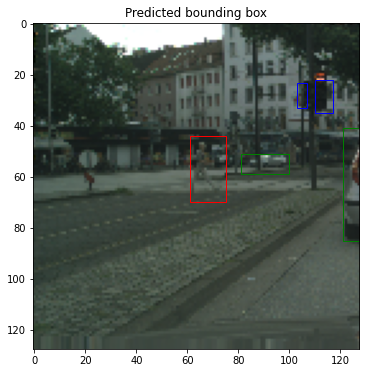

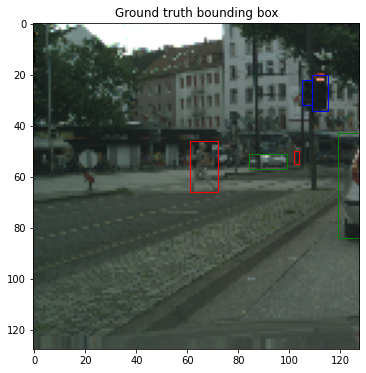

In [ ]:
# Customized function to transform raw image to proper type to feed into model
def imageEval(image):
    return torch.from_numpy(image.astype(np.float32).transpose(2,0,1))[None,:].cuda()

# Change model to evaluation
model.eval()
# Get one random image and feed into model
rand_img = images[rand_idx]
sample_pred = model(imageEval(rand_img)) # (1,8,8,8)
sample_pred_ = sample_pred.cpu().detach().numpy().squeeze()
# Perform low confidence suppression, non-maximum suppression
low_sup_sample_pred = low_confidence_suppression(sample_pred_)
nms_label = non_max_suppression(low_sup_sample_pred)
sample_rect_nms = reconstruct_raw_labels(nms_label, img_dim=128)
visualImgBbox(rand_img, sample_rect_nms, title='Predicted bounding box')

# Ground truth
gt_label = proc_label[rand_idx].numpy()
gt_raw_label = reconstruct_raw_labels(gt_label)
visualImgBbox(rand_img, gt_raw_label, title='Ground truth bounding box')

0.15939961241982825


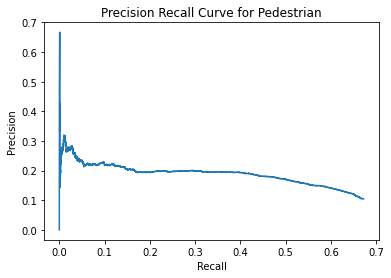

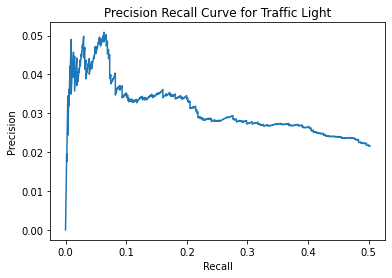

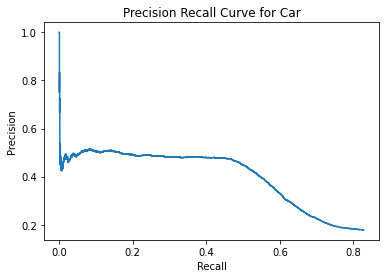

In [ ]:
# Evaluate model on all validation dataset
model.eval()
batch_size = 30
t_val = proc_image_val.shape[0] // batch_size
val_output = torch.zeros(proc_label_val.shape)
for val_batch_idx in range(t_val):
    val_curr_output = model(proc_image_val[val_batch_idx*batch_size : (val_batch_idx+1)*batch_size].cuda())
    val_output[val_batch_idx*batch_size : (val_batch_idx+1)*batch_size] = val_curr_output.cpu()
predictions = val_output.detach().numpy()
targets = proc_label_val.numpy()
mAP, pr_curve = mean_average_precision(predictions, targets)
# Evaluate mAP and precision recall curve for all validation set
print(mAP)
category = {0:'Pedestrian', 1:'Traffic Light', 2:'Car'}
for class_idx in range(3):
    plt.figure()
    plt.plot(pr_curve[class_idx][1], pr_curve[class_idx][0])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve for %s' % (category[class_idx]))

8. Explain any issues or challenges you had with your implementation. Explain the performance you achieved and any interesting observations you made while training your network. Discuss hypotheses for how you could improve the performance of your implementation further. (20%)

There are three main challenges we have encontered during the implementation of YOLO:
1. The first challenge comes when we calculate the IOU. Firstly, we code a bunch of if judgement to see whether the boxes would overlap ot not, which makes our code hard to read and algorithm not efficient. Later, we refer to the supplementary materials and found that using min max function could easily solve this.

2. The second challenge comes when we code the IOU loss, especially for the confidence loss, we firstly wrongly calculate the confidence score by 1/0 * IOU instead of objectness * IOU and can't pass the test on autograder. Then we see the post on the Ed discussions and fixed that up

3. The third issue arises when we code the precision recall curve. We at the beginning didn't realize that true positive shouldn't be reapeatedly count for calculating recall. And we are also a bit confused on how to code pr_curve for a whole set of data. Those problems are solved after the live coding session held be the TAs on Wednesday. 

As for the performance achieved by our network,
1. Our YOLO Network follows a typical learning track during training process, the loss is decreasing steadily, and achived relatively good performance when we validate them, as shown in the above images.

2. According to our calculation, during the training process (80% training set), our model achieve a mAP of about 20%, and on the 20% validation dataset, we achieved about 16% of mAP. The total data with scores we upload on the gradescope shows a mAP at around 30%. We think the difference may probably due to the approximation we made during calculating the area under PR curve, where we assume the AUC is calculated by summing up the area of multiple rectangle area under the precision-recall curve. Secondly, we speculate the major difference between our result and the Autograder score is caused by different calculation process, where in our case we collect all precision recall value pairs for the validation dataset images and then calculate the mAP. It is possible that we might get different mAP if we calcuate the AP value for each image batches in the validation dataset and then calculate the mean value to be the mean AP.

About the improving the performance:
1. From the result shown in the above cells, we can see that our model performs badly in detecting traffic lights, in fact, we think that the model we implemented here would neglect the detection for small objects. For further improvement, we may introduce the anchor boxes (as is stated in YOLO v2) so that the model doesn't need to learn the bounding box dimension for objects from scratch.

2. In this project, we have only one bounding boxes for a single grid cell, and we process the label and implement YOLO according to that pipeline. However, for images in which objects are really dense (close to each other), this would cause problems. For further improvement, we can introduce multiple boxes for a griding cell, or make our griding cell become more dense.

## Some Useful Online Materials

Original YOLO paper:  
https://arxiv.org/pdf/1506.02640.pdf

Intuitive Explanation:  
https://towardsdatascience.com/yolo-you-only-look-once-real-time-object-detection-explained-492dc9230006

YOLO Video Tutorial:  
https://www.youtube.com/watch?v=9s_FpMpdYW8&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=30

mean Average Precision:  
https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173

Intersection over Union:  
https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection

## Submission

Make sure you have run all cells in your notebook in order before you zip together your submission, so that all images/graphs appear in the output. 

For part (a), your submission should consist of this file and a pdf report. This report can simply be a pdf version of this document. Example conversion code below.

**Please save before exporting!**

In [13]:
!sudo apt-get update &> /dev/null
!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended &> /dev/null
!jupyter nbconvert --to pdf /content/drive/MyDrive/CIS680_HW2_copy.ipynb